<a href="https://colab.research.google.com/github/Fiona-cherutto/Satellite-Image/blob/main/Satellite_Image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Compute Satellite Image Statistics

In [ ]:
!apt install gdal-bin python-gdal python3-gdal
!pip install rasterio
!apt install python3-rtree
!pip install git+git://github.com/geopandas/geopandas.git
!pip install descartes
!pip install mapclassify
!pip install sentinelsat


Reading package lists... Done
Building dependency tree       
Reading state information... Done
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
The following additional packages will be installed:
  python3-numpy
Suggested packages:
  python-numpy-doc python3-nose python3-numpy-dbg
The following NEW packages will be installed:
  python3-gdal python3-numpy
0 upgraded, 2 newly installed, 0 to remove and 40 not upgraded.
Need to get 2,288 kB of archives.
After this operation, 13.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 python3-numpy amd64 1:1.13.3-2ubuntu1 [1,943 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python3-gdal amd64 2.2.3+dfsg-2 [346 kB]
Fetched 2,288 kB in 3s (863 kB/s)
Selecting previously unselected package python3-numpy.
(Reading database ... 160837 files and directories currently installed.)
Preparing to unpack .../python3-numpy_1%

In [ ]:
import pandas as pd
import numpy as np
import geopandas as gpd
import rasterio as rio
from rasterio.plot import show
from rasterio.mask import mask
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#downloading the files from the web and unzipping it
!wget https://www.dropbox.com/s/gf51dybqbujyjb2/Data.zip
!unzip Data.zip

--2021-08-03 06:02:41--  https://www.dropbox.com/s/gf51dybqbujyjb2/Data.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.82.18, 2620:100:6032:18::a27d:5212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.82.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/gf51dybqbujyjb2/Data.zip [following]
--2021-08-03 06:02:41--  https://www.dropbox.com/s/raw/gf51dybqbujyjb2/Data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uce1662ac5f388a099b2b721d5a5.dl.dropboxusercontent.com/cd/0/inline/BTgRfR2cPA4-7LsMqOH975-MzK7eteOUKbIvWgjSSuwnUBEoUIlThFWHZIo6m6mDHTiHVh-9fXoJHiNG1ENBon6n0ePxOk5Yn6oiPW9V7UHB5nRgVW0lGvXfqvh1j1dleJprx8y4wAzcrp8pvsI3TMJd/file# [following]
--2021-08-03 06:02:42--  https://uce1662ac5f388a099b2b721d5a5.dl.dropboxusercontent.com/cd/0/inline/BTgRfR2cPA4-7LsMqOH975-MzK7eteOUKbIvWgjSSuwnUBEoUIlThFWHZIo6m6mDHTiHVh-9fXoJHiNG1ENBon6n0ePxOk5Yn6o

In [ ]:
b8 = rio.open("/content/Data/20191101/B08-20191101.tif")
b4 = rio.open("/content/Data/20191101/B04-20191101.tif")
b3 = rio.open("/content/Data/20191101/B03-20191101.tif")
b2 = rio.open("/content/Data/20191101/B02-20191101.tif")

In [ ]:
#width and height of the images
b4.count, b4.width, b4.height

(1, 479, 429)

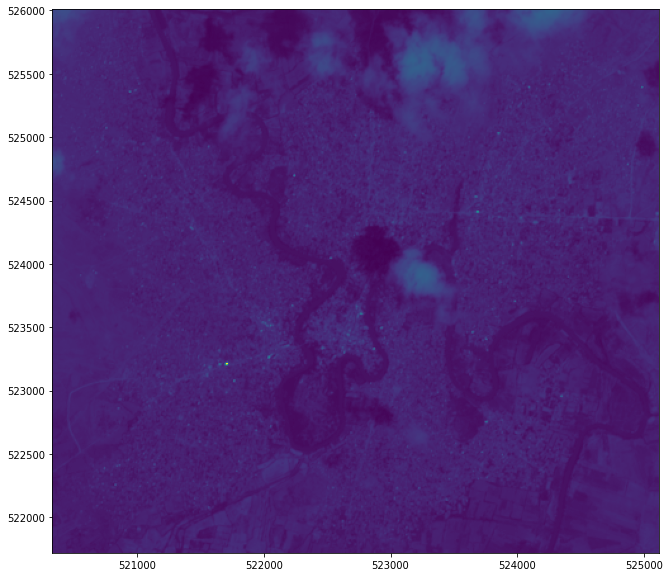

In [ ]:
#plot the data to see and explore the satellite images
fig, ax = plt.subplots(1, figsize=(12, 10))
show(b3, ax=ax)
plt.show()

In [ ]:
#buildings table which we will use to store the statistical summaries derived from the satellite image using Geopandas to read the data
buildings = gpd.read_file("/content/Data/shapefiles/osm_buildings.shp")
buildings = buildings[["osm_id", "building", "geometry"]]
buildings.head()

,osm_id,building,geometry
0,8275560,yes,"POLYGON ((521839.828 524323.388, 521837.607 52..."
1,8276697,yes,"POLYGON ((522700.756 523641.273, 522727.020 52..."
2,8280395,yes,"POLYGON ((523000.403 523492.953, 523003.418 52..."
3,None,yes,"POLYGON ((521087.015 523190.338, 521095.931 52..."
4,None,yes,"POLYGON ((521096.268 523212.801, 521104.110 52..."


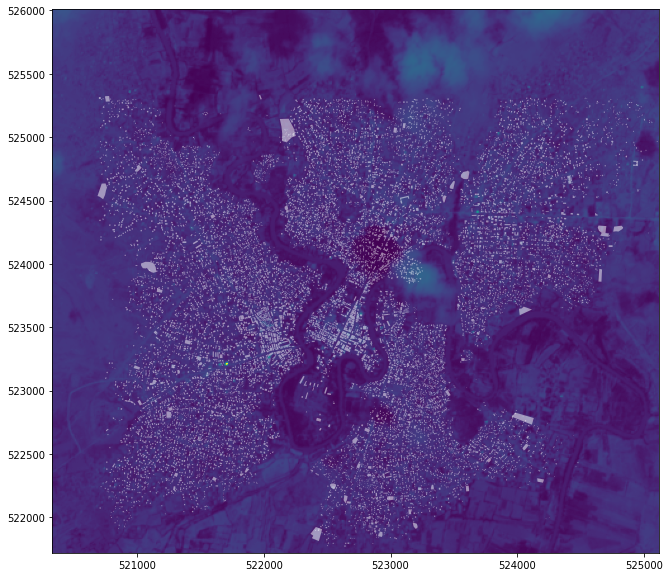

In [ ]:
#plot the buildings on top of the Sentinel  images.
fig, ax = plt.subplots(figsize=(12, 10))
show(b4, ax=ax)
buildings.plot(ax=ax, color="white", alpha=.50)
plt.show();

In [ ]:
green = b3.read()
nir = b8.read()
ndwi = (nir.astype(float)-green.astype(float))/(nir+green)

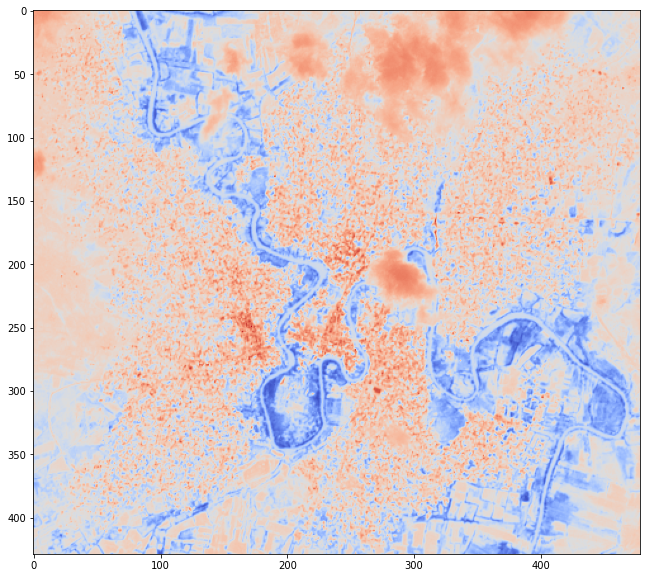

In [ ]:
#NDWI arrays plotted with Rasterio
fig, ax = plt.subplots(1, figsize=(12, 10))
show(ndwi, ax=ax, cmap="coolwarm_r")
plt.show()

In [ ]:
#saving the NDWI arrays as a raster image
meta = b4.meta
meta.update(driver='GTiff')
meta.update(dtype=rio.float32)
with rio.open('NDWI.tif', 'w', **meta) as dst:
 dst.write(ndwi.astype(rio.float32))
ndwi_raster = rio.open('NDWI.tif')

In [ ]:
#Now, that we have calculated the NDWI values, it is time to derive statistics from 
#the NDWI raster image and merge to our buildings table. We use Rasterio mask functionality to get the cell values from the NDWI raster image.

def derive_stats(geom, data=ndwi_raster, **mask_kw):
  masked, mask_transform = mask(dataset=data, shapes=(geom,),
crop=True, all_touched=True, filled=True)
  return masked

In [ ]:
#We can now derive the values that we want. Let’s say we are interested in getting the mean values of NDWI for each building.
# We create a column for that “mean_ndwi” and pass our function to apply the building’s geometry and also apply to mean from using Numpy.
buildings['mean_ndwi'] = buildings.geometry.apply(derive_stats).apply(np.mean)

In [ ]:
#maximum NDWI values for each building
buildings['max_ndwi'] = buildings.geometry.apply(derive_stats).apply(np.max)
buildings.head()

,osm_id,building,geometry,mean_ndwi,max_ndwi
0,8275560,yes,"POLYGON ((521839.828 524323.388, 521837.607 52...",0.207663,0.263993
1,8276697,yes,"POLYGON ((522700.756 523641.273, 522727.020 52...",0.066127,0.255757
2,8280395,yes,"POLYGON ((523000.403 523492.953, 523003.418 52...",0.067684,0.247811
3,None,yes,"POLYGON ((521087.015 523190.338, 521095.931 52...",0.186061,0.268627
4,None,yes,"POLYGON ((521096.268 523212.801, 521104.110 52...",0.187913,0.265823


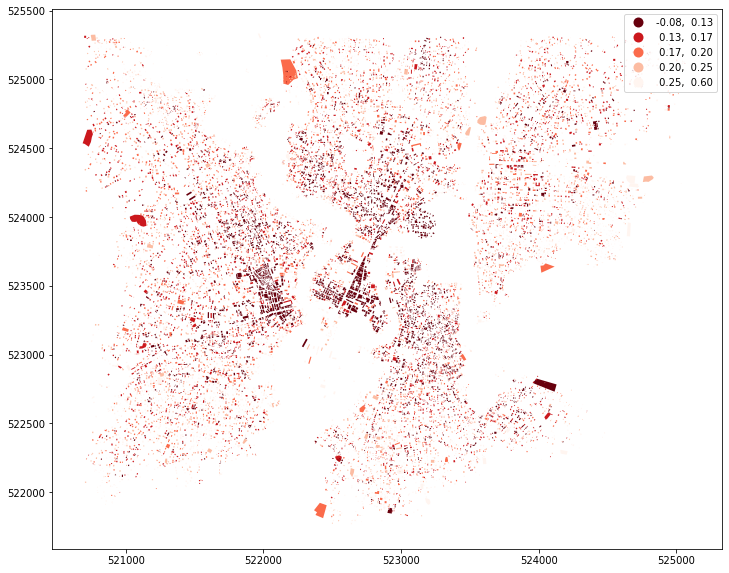

In [ ]:
#create a figure and a set of subplots for the axis object by showing mean NDWI
fig, ax = plt.subplots(figsize=(12,10))
buildings.plot(column="mean_ndwi", ax=ax, cmap="Reds_r", scheme='quantiles', legend=True)

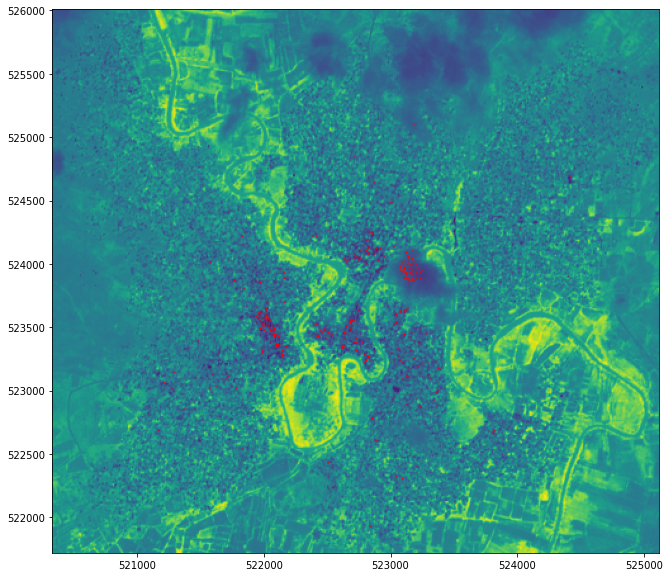

In [ ]:
#we will plot the figure of max_ndwi through ndwi raster of residential areas in red color

fig, ax = plt.subplots(figsize=(12, 10))
show(ndwi_raster, ax=ax)
buildings[buildings["max_ndwi"].between(0, 0.1)].plot(color="red", ax=ax)
plt.show();